In [17]:
from __future__ import division , print_function , absolute_import
import tensorflow as tf
from tensorflow.keras import Model , layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [18]:
num_features = 784 # data features (img shape: 28*28).

# Training parameters.
lr_generator = 0.0002
lr_discriminator = 0.0002
training_steps = 20000
batch_size = 128
display_step = 500

# Network parameters.
noise_dim = 100 # Noise data points.

In [19]:
(x_train , y_train) , (x_test , y_test) = mnist.load_data()
x_train , x_test = np.array(x_train , np.float32) , np.array(x_test , np.float32)
x_train , x_test = x_train / 255. , x_test /255.

In [20]:
train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

In [21]:
#create Tf Model
class Generator(Model):
    # Set layers
    def __init__(self):
        super(Generator,self).__init__()
        self.fc1        = layers.Dense(7*7*128)
        self.bn1        = layers.BatchNormalization()
        self.conv2tr1   = layers.Conv2DTranspose(64,5,2,'SAME')
        self.bn2        = layers.BatchNormalization()
        self.conv2tr2   =  layers.Conv2DTranspose(1,5,2,'SAME')
        # Set Fowrard Pass
    def call(self , x , is_training = False):
        x = self.fc1(x)
        x = self.bn1(x , training = is_training)
        x = tf.nn.leaky_relu(x)
        x = tf.reshape(x, shape=[-1, 7, 7, 128])
        x = self.conv2tr1(x)
        x = self.bn2(x,training = is_training)
        x = tf.nn.leaky_relu(x)
        x = self.conv2tr2(x)
        x = tf.nn.tanh(x)
        return x    

In [22]:
#Generator Network
class Discriminator(Model):
    #Set layers
    def __init__(self):
        super(Discriminator,self).__init__()
        self.conv1      = layers.Conv2D(64,5,2,'SAME')
        self.bn1        = layers.BatchNormalization()
        self.conv2      = layers.Conv2D(128,5,2,'SAME')
        self.bn2        = layers.BatchNormalization()
        self.flatten    = layers.Flatten()
        self.fc1        = layers.Dense(1024)
        self.bn3        = layers.BatchNormalization()
        self.fc2        = layers.Dense(2)
    #Set Forward Pass
    def call(self , x , is_training = False ):
         x = tf.reshape(x,[-1 , 28 , 28 , 1])
         x = self.conv1(x)
         x = self.bn1(x,training = is_training)
         x = tf.nn.leaky_relu(x)
         x = self.conv2(x)
         x = self.bn2(x , training = is_training)
         x = tf.nn.leaky_relu(x)
         x = self.flatten(x)
         x = self.fc1(x)
         x = self.bn3(x , training = is_training)
         x = tf.nn.leaky_relu(x)
         return self.fc2(x)

#Build Neural Network Model

generator     = Generator()
discriminator = Discriminator()


In [23]:
#Losses
def generator_loss(reconstructed_image):
    gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
     logits = reconstructed_image , labels = tf.ones([batch_size],dtype=tf.int32)))
    return gen_loss
def discriminator_loss(disc_fake , disc_real):
    disc_loss_real = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
           logits = disc_real , labels=tf.ones([batch_size],dtype = tf.int32)))
    disc_loss_fake = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
           logits = disc_fake , labels = tf.zeros([batch_size],dtype =tf.int32)))
    return disc_loss_real + disc_loss_fake

#Optimizers
optimizer_gen  = tf.optimizers.Adam(learning_rate=lr_generator)
optimizer_disc = tf.optimizers.Adam(learning_rate=lr_discriminator)
              

In [24]:
#optimazation proccess
from dis import dis


def run_optimization(real_images):
    real_images = real_images *2. -1.
    #Generate Noise
    noise = np.random.normal(-1.,1.,size=[batch_size,noise_dim]).astype(np.float32)

    with tf.GradientTape() as g:
        fake_images = generator(noise,is_training = True)
        disc_fake   = discriminator(fake_images,is_training=True)
        disc_real   = discriminator(real_images,is_training=True)
        
        disc_loss   = discriminator_loss(disc_fake,disc_real)

    #Training Variables for each optimizer
    gradients_disc = g.gradient(disc_loss , discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients_disc,discriminator.trainable_variables))


    #Generate Noise
    noise = np.random.normal(-1.,1.,size=[batch_size,noise_dim]).astype(np.float32)

    with tf.GradientTape() as g:
         fake_images    = generator(noise,is_training=True)
         disc_fake      = discriminator(fake_images,is_training=True)
         gen_loss       = generator_loss(disc_fake)

    gradients_gen = g.gradient(gen_loss,generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients_gen,generator.trainable_variables))
    return gen_loss , disc_loss

In [25]:
#Run training for the given number of steps.
for step , (batch_x , _) in enumerate(train_data.take(training_steps+1)):

    if step == 0:
       #Generate Noise.

       noise     = np.random.normal(-1.,1.,size=[batch_size,noise_dim]).astype(np.float32)
       gen_loss  = generator_loss(discriminator(generator(noise)))
       disc_loss = discriminator_loss(discriminator(batch_x),discriminator(generator(noise)))
       print("initial: gen loss: %f, disc_loss: %f" % (gen_loss,disc_loss))
       continue

    #Run the optimization
    gen_loss , disc_loss = run_optimization(batch_x)

    if step % display_step == 0:
        print("step: %i , gen_loss: %f, disc_loss: %f" % (step, gen_loss, disc_loss))

initial: gen loss: 0.693858, disc_loss: 1.380566
step: 500 , gen_loss: 2.406141, disc_loss: 0.558756
step: 1000 , gen_loss: 2.028554, disc_loss: 0.460088
step: 1500 , gen_loss: 2.241864, disc_loss: 0.525420
step: 2000 , gen_loss: 2.254280, disc_loss: 0.355051
step: 2500 , gen_loss: 2.906086, disc_loss: 0.526968
step: 3000 , gen_loss: 2.711125, disc_loss: 0.308948
step: 3500 , gen_loss: 2.930726, disc_loss: 0.248478
step: 4000 , gen_loss: 3.151756, disc_loss: 0.276233
step: 4500 , gen_loss: 3.845295, disc_loss: 0.231224
step: 5000 , gen_loss: 3.444754, disc_loss: 0.315326
step: 5500 , gen_loss: 3.469821, disc_loss: 0.175793
step: 6000 , gen_loss: 3.892690, disc_loss: 0.119172


KeyboardInterrupt: 

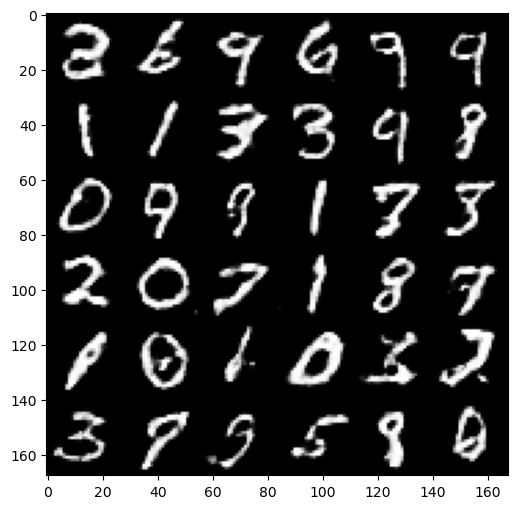

In [26]:
n = 6 
canvas = np.empty((28* n , 28*n))
for i in range(n):
    #Noise input
    z = np.random.normal(-1.,1.,size=[n,noise_dim]).astype(np.float32)
    #Generate Image from noise
    g = generator(z).numpy()
    #Rescale to original
    g = -1 * (g+1.) / 2

    #Reverse colours for better display
    g = -1* (g-1)
    
    for j in range(n):
        #Draw the generated digits
        canvas[i * 28:(i+1) * 28 , j * 28:(j+1)*28] = g[j].reshape([28,28])


plt.figure(figsize=(n,n))
plt.imshow(canvas,origin="upper", cmap="gray")
plt.show()        
